In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

import glob
from scipy.stats.kde import gaussian_kde
from numpy import linspace
import time
from scipy import interpolate
import seaborn as sns

from ipywidgets import IntProgress
from IPython.display import display

In [2]:
#Set latex environment for plots/labels
# matplotlib.rc('font', **{'family': 'serif'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams.update({'font.family':'serif'})


fl=22
fm=18
fs=16


In [3]:
from natal_kick_tools import mandel_muller_likelihood_functions as mmf
from natal_kick_tools import likelihood_plot_functions as lpf

In [15]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = fm, second=False, labelpad=None, setMinor=True):
#     matplotlib.rc('font', **{'family': 'serif'})

    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


In [5]:
# Define the models of interest
bh_kicks=[200]
ns_kicks = [300, 350, 400, 450, 500, 550, 600, 650, 700]
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5]

# Define the location of the posterior data
pulsar_data_loc = "../correctedPulsarPosteriors/correctedVtData"

# Read Velocity Data

## Model Velocities

In [6]:
# Define a dictionary to map v_ns and sigma to their arrays
kick_models = {}
sig = len(sigmas)
vns = len(ns_kicks)

for i in range(len(ns_kicks)):
    kick_models[f"NS_{ns_kicks[i]}_RANGE"] = np.arange(i*sig, (i*sig)+sig, 1)

for i in range(len(sigmas)):
    kick_models[f"SIGMA_{sigmas[i]}_RANGE"] = np.arange(i, (vns*sig) + i, sig)

kick_models["ALL"] = np.arange(0, vns*sig, 1)

In [7]:
# Read model velocity data (takes ~2 min)

start = time.time()

NS_KICKS_3D = []
NS_KICKS_2D = []
NS_KICK_MULT = [] 
SIGMAS = []

f = IntProgress(min=0, max=sig*vns) # instantiate the bar
display(f) # display the bar

for ns_kick in ns_kicks:
    for sigma in sigmas:
        f.value +=1
        fname = f"model_velocities_bse/vns_{ns_kick}_sigma_{sigma}_velocities"
        v_3d, v_2d = np.loadtxt(fname, skiprows=1, unpack=True)
        NS_KICKS_3D.append(v_3d)
        NS_KICKS_2D.append(v_2d)
        NS_KICK_MULT.append(ns_kick)
        SIGMAS.append(sigma)    
        
end = time.time()
print(end - start, "s")

IntProgress(value=0, max=45)

150.221111536026 s


# Read Likelihood Data

In [8]:
p_models = []
columns = [] # labels for plotting model likelihoods in next cell
for ns_kick in ns_kicks:
    for sigma in sigmas:
        fname = f"calculatedModelLikelihoods_bse/vns_{ns_kick}_sigma_{sigma}"
        all_likelihoods = np.loadtxt(fname)
        p_models.append(np.prod(all_likelihoods))
        
        col_name = f"vns_{ns_kick}_sigma_{sigma}"
        columns.append(col_name)

# normalize and reshape the array
p_models = p_models/np.max(p_models)

p_models_2d = p_models.reshape([len(ns_kicks), len(sigmas)])
print(np.array2string(p_models_2d, formatter={'float_kind': '{0:.3f}'.format}))

[[0.000 0.000 0.000 0.000 0.000]
 [0.001 0.003 0.004 0.002 0.001]
 [0.005 0.052 0.089 0.044 0.012]
 [0.030 0.264 0.444 0.210 0.049]
 [0.078 0.564 1.000 0.408 0.085]
 [0.074 0.473 0.839 0.393 0.068]
 [0.034 0.227 0.423 0.197 0.030]
 [0.012 0.072 0.124 0.058 0.008]
 [0.003 0.014 0.025 0.011 0.002]]


In [9]:
# Identify the most likely models
M = sorted(zip(p_models), reverse=True)[:5]
MAX_INDICES = np.where(p_models==M)[1]

labels = []
for i in range(len(MAX_INDICES)):
    labels.append("v$_{ns}$=" + f"{NS_KICK_MULT[MAX_INDICES[i]]}" + ", $\sigma_{ns}$=" + f"{SIGMAS[MAX_INDICES[i]]}")

In [10]:
MAX_INDICES

array([22, 27, 21, 26, 17])

# Load Posterior Data

In [11]:
# Takes about 30 s
start = time.time()

vt_all = []

f = IntProgress(min=0, max=len(glob.glob('../correctedPulsarPosteriors/correctedVtData/*.bootstraps'))) # instantiate the bar
display(f) # display the bar

for file in glob.glob('../correctedPulsarPosteriors/correctedVtData/*.bootstraps'):
    f.value +=1
    vt_all.append(np.loadtxt(file, unpack=True, usecols=5))

end = time.time()
print(end - start, "s")

IntProgress(value=0, max=81)

38.287092447280884 s


In [12]:
PLOT_DATA = [vt_all, NS_KICKS_2D, NS_KICK_MULT, SIGMAS] # Needed to make all the cdf functions work

# CDF Plots without binning

/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same argument

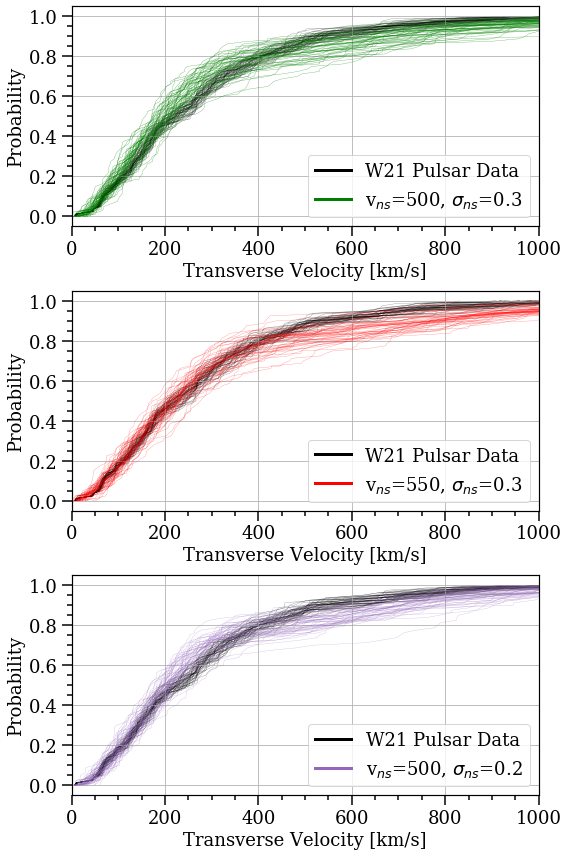

In [21]:
n_cdf = 50
alpha = 0.5
n_draws = len(vt_all)
lw = 0.3
lw_med = lw

f, (ax1, ax2, ax3)= plt.subplots(3, 1,  figsize=(8,12))

plt.subplot(3, 1, 1)
lpf.plot_median_pulsar_cdf_no_bins(*PLOT_DATA, n_cdf, n_draws, alpha=alpha, color='k', label='W21 Pulsar Data', zorder=1, lw=lw, lw_med=lw_med)
lpf.plot_median_model_cdf_no_bins(*PLOT_DATA, n_cdf, MAX_INDICES[0], n_draws, alpha=0.7, color='g', label=labels[0], zorder=2, lw=lw, lw_med=lw_med)
plt.xlim(0,1000)
layoutAxes(ax=plt.subplot(3, 1, 1), nameX='Transverse Velocity [km/s]', nameY='Probability', fontsize=fm);
leg = plt.legend(fontsize=fm)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_linewidth(3)
plt.grid()
plt.tight_layout()


plt.subplot(3, 1, 2)
lpf.plot_median_pulsar_cdf_no_bins(*PLOT_DATA, n_cdf, n_draws, alpha=alpha, color='k', label='W21 Pulsar Data', zorder=1, lw=lw, lw_med=lw_med)
lpf.plot_median_model_cdf_no_bins(*PLOT_DATA, n_cdf, MAX_INDICES[1], n_draws, alpha=alpha, color='r', label=labels[1], zorder=2, lw=lw, lw_med=lw_med)
plt.xlim(0,1000)
layoutAxes(ax=plt.subplot(3, 1, 2), nameX='Transverse Velocity [km/s]', nameY='Probability', fontsize=fm);
leg = plt.legend(fontsize=fm)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_linewidth(3)
plt.grid()
plt.tight_layout()


plt.subplot(3, 1, 3)
lpf.plot_median_pulsar_cdf_no_bins(*PLOT_DATA, n_cdf, n_draws, alpha=alpha, color='k', label='W21 Pulsar Data', zorder=1, lw=lw, lw_med=lw_med)
lpf.plot_median_model_cdf_no_bins(*PLOT_DATA, n_cdf, MAX_INDICES[2], n_draws, alpha=alpha, color='C4', label=labels[2], zorder=2, lw=lw, lw_med=lw_med)
plt.xlim(0,1000)
layoutAxes(ax=plt.subplot(3, 1, 3), nameX='Transverse Velocity [km/s]', nameY='Probability', fontsize=fm);
leg = plt.legend(fontsize=fm)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_linewidth(3)
plt.grid()
plt.tight_layout()


plt.savefig('plots/model_cdfs_bse.pdf')

plt.show()

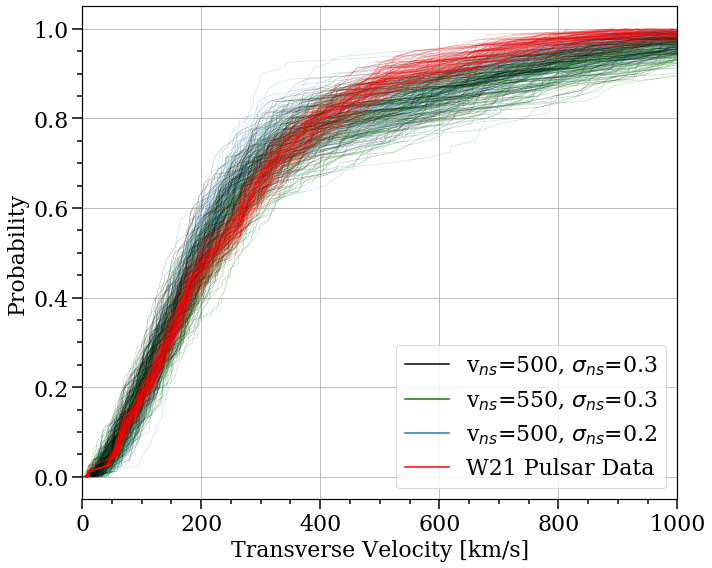

In [21]:
n_cdf = 100
alpha = 0.3
n_draws = len(vt_all)
lw = 0.5

f, ax= plt.subplots(1, 1,  figsize=(10,8)) 

lpf.plot_model_cdf_no_bins(*PLOT_DATA, n_cdf, MAX_INDICES[0], n_draws, alpha=alpha, color='k', label=labels[0], zorder=3, lw=lw)
lpf.plot_model_cdf_no_bins(*PLOT_DATA, n_cdf, MAX_INDICES[1], n_draws, alpha=alpha, color='g', label=labels[1], zorder=2, lw=lw)
lpf.plot_model_cdf_no_bins(*PLOT_DATA, n_cdf, MAX_INDICES[2], n_draws, alpha=alpha, color='C0', label=labels[2], zorder=1, lw=lw)
lpf.plot_pulsar_cdf_no_bins(*PLOT_DATA, n_cdf, n_draws, alpha=alpha, color='r', label='W21 Pulsar Data', zorder=4, lw=lw)


# # Clean plots for comparison
# lw=3
# lpf.plot_model_cdf(*PLOT_DATA, 1, MAX_INDICES[0], label=labels[0], n_draws=500000, color='k', alpha=1, lw=lw)
# lpf.plot_model_cdf(*PLOT_DATA, 1, MAX_INDICES[1], label=labels[1], n_draws=500000, color='g', alpha=1, lw=lw)
# lpf.plot_model_cdf(*PLOT_DATA, 1, MAX_INDICES[2], label=labels[2], n_draws=500000, color='C0', alpha=1, lw=lw)
# lpf.plot_avg_posterior_cdf(*PLOT_DATA, 1000, n_bins=n_bins, n_draws=n_draws, color='r', lw=lw, label="W21 Pulsar Data")


plt.xlim(0,1000)

layoutAxes(ax=ax, fontsize=fl)
plt.xlabel('Transverse Velocity [km/s]', fontsize=fl)
plt.ylabel('Probability', fontsize=fl)

leg = plt.legend(fontsize=fl)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.grid()
plt.tight_layout()
plt.show()


# PDF and CDF Plots

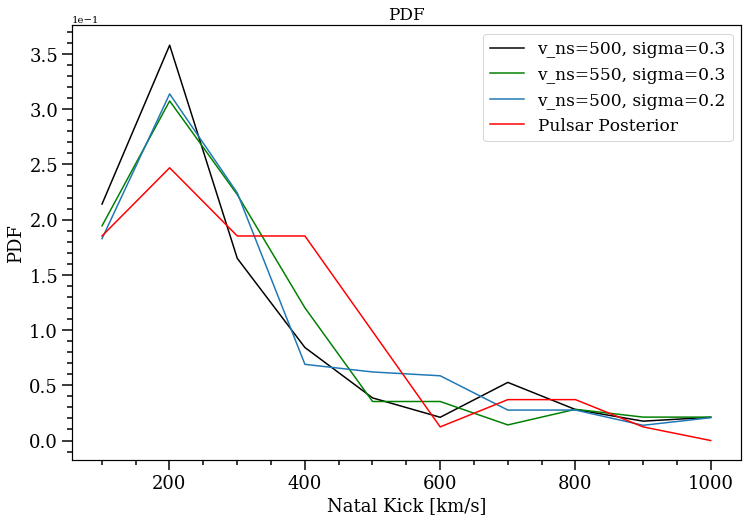

In [22]:
f, ax= plt.subplots(1, 1,  figsize=(12,8)) 

lpf.plot_model_pdf(*PLOT_DATA, MAX_INDICES[0], color='k')
lpf.plot_model_pdf(*PLOT_DATA, MAX_INDICES[1], color='g')
lpf.plot_model_pdf(*PLOT_DATA, MAX_INDICES[2], color='C0')

lpf.plot_posterior_pdf(*PLOT_DATA, color='r')


layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='PDF')

plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

plt.title(f"PDF", fontsize=17)

leg = plt.legend(fontsize=17)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
# plt.semilogx()
plt.show()


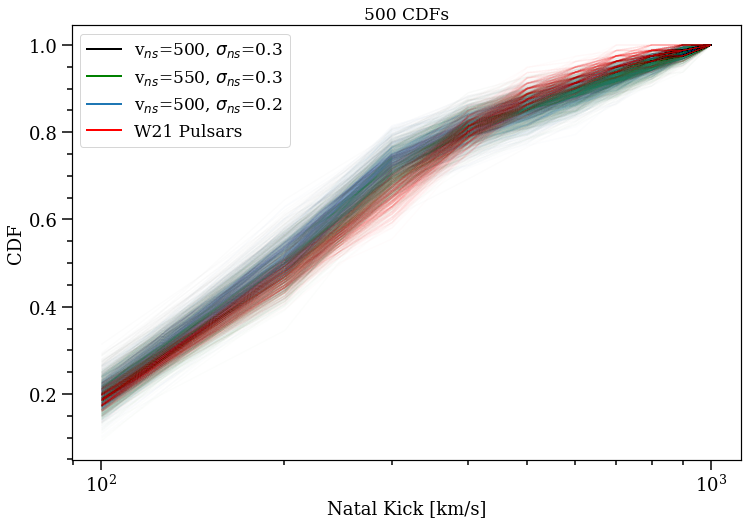

Plot completed in 26.803545 s


In [23]:
n_cdf = 500
n_draws = 200
alpha = 5/n_cdf

f, ax= plt.subplots(1, 1,  figsize=(12,8)) 

start = time.time()

lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[0], n_draws=n_draws, color='k', label=labels[0], alpha=alpha)
lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[1], n_draws=n_draws, color='g', label=labels[1],alpha=alpha)
lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[2], n_draws=n_draws, color='C0', label=labels[2],alpha=alpha)

# Posterior CDF always contains len(vt_all) data points in current implementation. 
# See 'draw_posterior_cdf' function for alternate implementation with n_draws data points
lpf.plot_posterior_cdf(*PLOT_DATA, n_cdf, n_draws=n_draws, color='r', alpha=alpha, label="W21 Pulsars")



layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='CDF')

plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

plt.title(f"{n_cdf} CDFs", fontsize=17)

leg = plt.legend(fontsize=17)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
plt.semilogx()
plt.show()

end = time.time()
print(f"Plot completed in {end - start:2f} s")

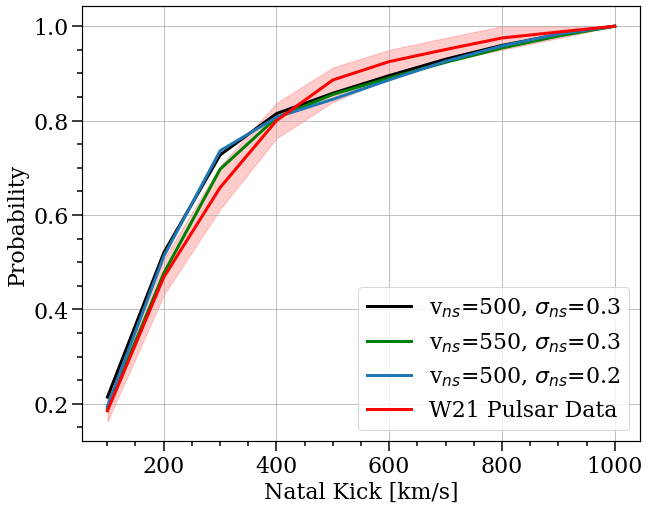

Plot completed in 12.328070 s


In [24]:
n_bins = 10

n_cdf = 1
n_cdf_posterior = 1000

n_draws = 500000
posterior_draws = 89

start = time.time()


f, ax= plt.subplots(1, 1,  figsize=(10,8)) 

lw=3

lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[0], label=labels[0], n_draws=n_draws, color='k', alpha=1, lw=lw)
lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[1], label=labels[1], n_draws=n_draws, color='g', alpha=1, lw=lw)
lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[2], label=labels[2], n_draws=n_draws, color='C0', alpha=1, lw=lw)


lpf.plot_avg_posterior_cdf(*PLOT_DATA, n_cdf_posterior, n_bins=n_bins, n_draws=posterior_draws, color='r', lw=lw, label="W21 Pulsar Data")


layoutAxes(ax=ax, fontsize=fl)
plt.xlabel('Natal Kick [km/s]', fontsize=fl)
plt.ylabel('Probability', fontsize=fl)

plt.legend(fontsize=fl)
    
    
# plt.semilogx()
plt.grid()
# plt.savefig('plots/model_cdfs_bse.pdf')
plt.show()


end = time.time()
print(f"Plot completed in {end - start:2f} s")

# Comparison to Hobbs Maxwellian

In [25]:
from scipy.stats import maxwell

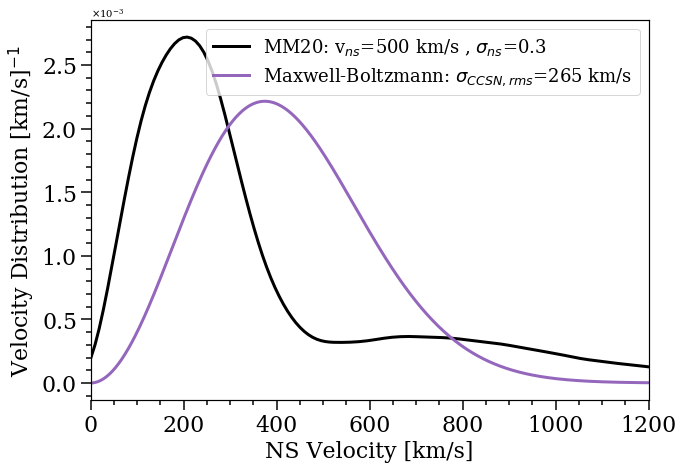

In [26]:
f, ax= plt.subplots(1, 1,  figsize=(10,7)) 

best_index = MAX_INDICES[0]

kde_best = gaussian_kde( NS_KICKS_3D[best_index] )
kde_best_dist_space = linspace( min(NS_KICKS_3D[best_index]), max(NS_KICKS_3D[best_index]), 300 )
label_str = r'MM20: v$_{ns}$=' + '{nskick}'.format(nskick=NS_KICK_MULT[best_index]) + ' km/s , $\sigma_{ns}$=' + '{sig}'.format(sig=SIGMAS[best_index])

plt.plot( kde_best_dist_space, kde_best(kde_best_dist_space), 'k', lw=3, label=label_str)

x = np.linspace(0, 1200, 500)
plt.plot(x, maxwell.pdf(x, 0, 265), 'tab:purple', lw=3, label='Maxwell-Boltzmann: $\sigma_{CCSN, rms}$=265 km/s')

plt.rc('font', size=fm)

plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0), useMathText=True)

plt.xlim(0, 1200)

layoutAxes(ax=ax, fontsize = fl)
plt.xlabel('NS Velocity [km/s]', fontsize=fl)
plt.ylabel('Velocity Distribution [km/s]$^{-1}$', fontsize=fl)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

plt.legend(fontsize=fm, loc='upper right')

plt.show()


# CDF Comparisons

In [27]:
# Get all the cdfs needed for KS test
n_cdf = 1
n_bins = 30
n_draws = 10000
bins, cdf_0, cdf_min, cdf_max, draws  = lpf.get_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[0], n_bins=n_bins, n_draws=n_draws)
bins, cdf_1, cdf_min, cdf_max, draws  = lpf.get_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[1], n_bins=n_bins, n_draws=n_draws)
bins, cdf_2, cdf_min, cdf_max, draws  = lpf.get_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[2], n_bins=n_bins, n_draws=n_draws)

bins_posterior, cdf_posterior, cdf_pos_min, cdf_pos_max, draws = lpf.get_avg_posterior_cdf(*PLOT_DATA, n_cdf=500, n_bins=n_bins)


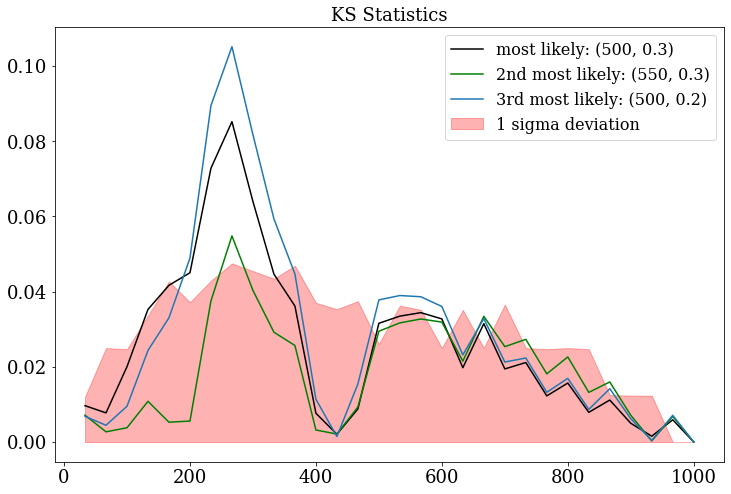

In [28]:
# Plot the KS-statistics

f, ax= plt.subplots(1, 1,  figsize=(12,8)) 
plt.plot(bins, np.abs(cdf_0 - cdf_posterior), color='k', label=f'most likely: ({NS_KICK_MULT[MAX_INDICES[0]]}, {SIGMAS[MAX_INDICES[0]]})')
plt.plot(bins, np.abs(cdf_1 - cdf_posterior), color='g', label=f'2nd most likely: ({NS_KICK_MULT[MAX_INDICES[1]]}, {SIGMAS[MAX_INDICES[1]]})')
plt.plot(bins, np.abs(cdf_2 - cdf_posterior), color='C0', label=f'3rd most likely: ({NS_KICK_MULT[MAX_INDICES[2]]}, {SIGMAS[MAX_INDICES[2]]})')

plt.fill_between(bins, 0, cdf_pos_max - cdf_posterior, color='r', alpha=0.3, label='1 sigma deviation')

plt.title("KS Statistics", fontsize=fm)

plt.legend(fontsize=fs)
plt.show()